# KOH Example

## 1. 라이브러리 임포트

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트

In [2]:
# c stands for computed, p stands for field (physical process).
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")
df_p = pd.read_csv("../dataset/datafield_hourly.csv")

In [3]:
df_c

,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [4]:
df_p

,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 

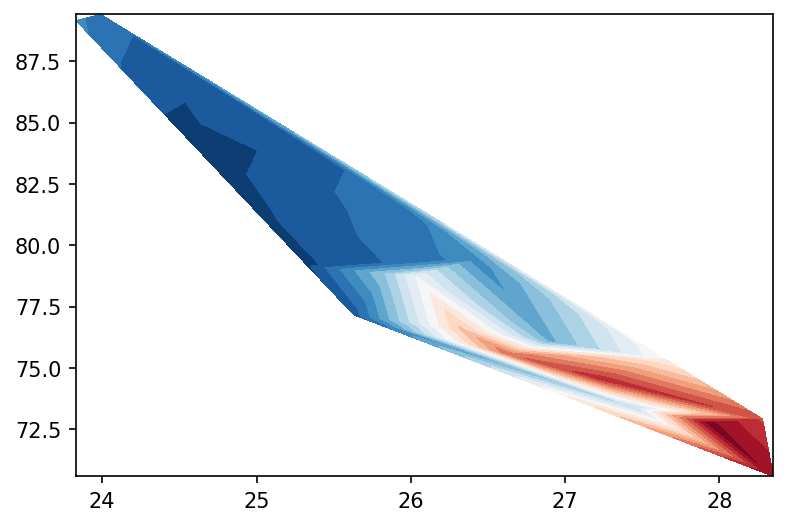

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.tricontourf(
    df_p.iloc[:, 1],
    df_p.iloc[:, 2],
    df_p.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)
plt.show()

# 4. KOH 모델 정의

### 4-1. 모델 정의를 위한 데이터 변수명 설정

In [6]:
# Data from computed process
y_c = df_c.iloc[:, 0].values
x_c = df_c.iloc[:, 1:3].values
t_c = df_c.iloc[:, 3:].values
print(y_c.shape, x_c.shape, t_c.shape)

# Data from physical process
y_p = df_p.iloc[:, 0].values
x_p = df_p.iloc[:, 1:3].values
print(y_p.shape, x_p.shape)


(240,) (240, 2) (240, 3)
(24,) (24, 2)


### 4-2. PyMC 모델 정의

In [7]:
with pm.Model() as koh_model:
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta).
    # 5차원 인풋 사용 (x1, x2, t1, t2, t3).
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)
    eta_eta = pm.HalfCauchy("eta_eta", beta=2)
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)
    gp_eta = pm.gp.Latent(cov_func=cov_eta)

    # 2. 모델 불일치 함수 GP (delta).
    # 2차원 인풋 사용 (x1, x2).
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    eta_delta = pm.HalfCauchy("eta_delta", beta=2)
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)
    gp_delta = pm.gp.Latent(cov_func=cov_delta)

    # 3. 컴퓨터 모델 가능도 및 관측 정의.
    X_c = np.hstack([x_c, t_c])
    f_c_eta = gp_eta.prior("f_c_eta", X=X_c)

    # 컴퓨터 계산 노이즈 정의.
    sigma_c = pm.HalfNormal("sigma_c", sigma=1)

    # 관측 데이터 정의.
    y_c_obs = pm.Normal("y_c_obs", mu=f_c_eta, sigma=sigma_c, observed=y_c)

    # 4. 물리 모델 가능도 및 관측 정의.

    # theta prior 정의 (양수 값만 가능). t1, t2, t3의 3차원.
    theta = pm.Uniform("theta", lower=0, upper=20, shape=3)

    X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)
    f_p_eta = gp_eta.prior("f_p_eta", X=X_p)
    f_p_delta = gp_delta.prior("f_p_delta", X=x_p)

    f_p = pm.Deterministic("f_p", f_p_eta + f_p_delta)

    # 물리 계산 노이즈 정의.
    sigma_p = pm.HalfNormal("sigma_p", sigma=1)

    # 관측 데이터 정의.
    y_p_obs = pm.Normal("y_p_obs", mu=f_p, sigma=sigma_p, observed=y_p)

# 5. Sampling 수행

In [8]:
with koh_model:
    trace = pm.sample(
        draws=100, tune=100, chains=1, cores=1,
        nuts_sampler="numpyro",
        target_accept=0.95,
        # rogressbar=False,                     # 여기
        # nuts_sampler_kwargs={"progress_bar": False}, 
    )

/home/xlsw91/Workspace/pymc-examples/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
sample: 100%|██████████| 200/200 [07:12<00:00,  2.16s/it, 1023 steps of size 1.22e-04. acc. prob=0.93]
Only one chain was sampled, this makes it impossible to run some convergence checks


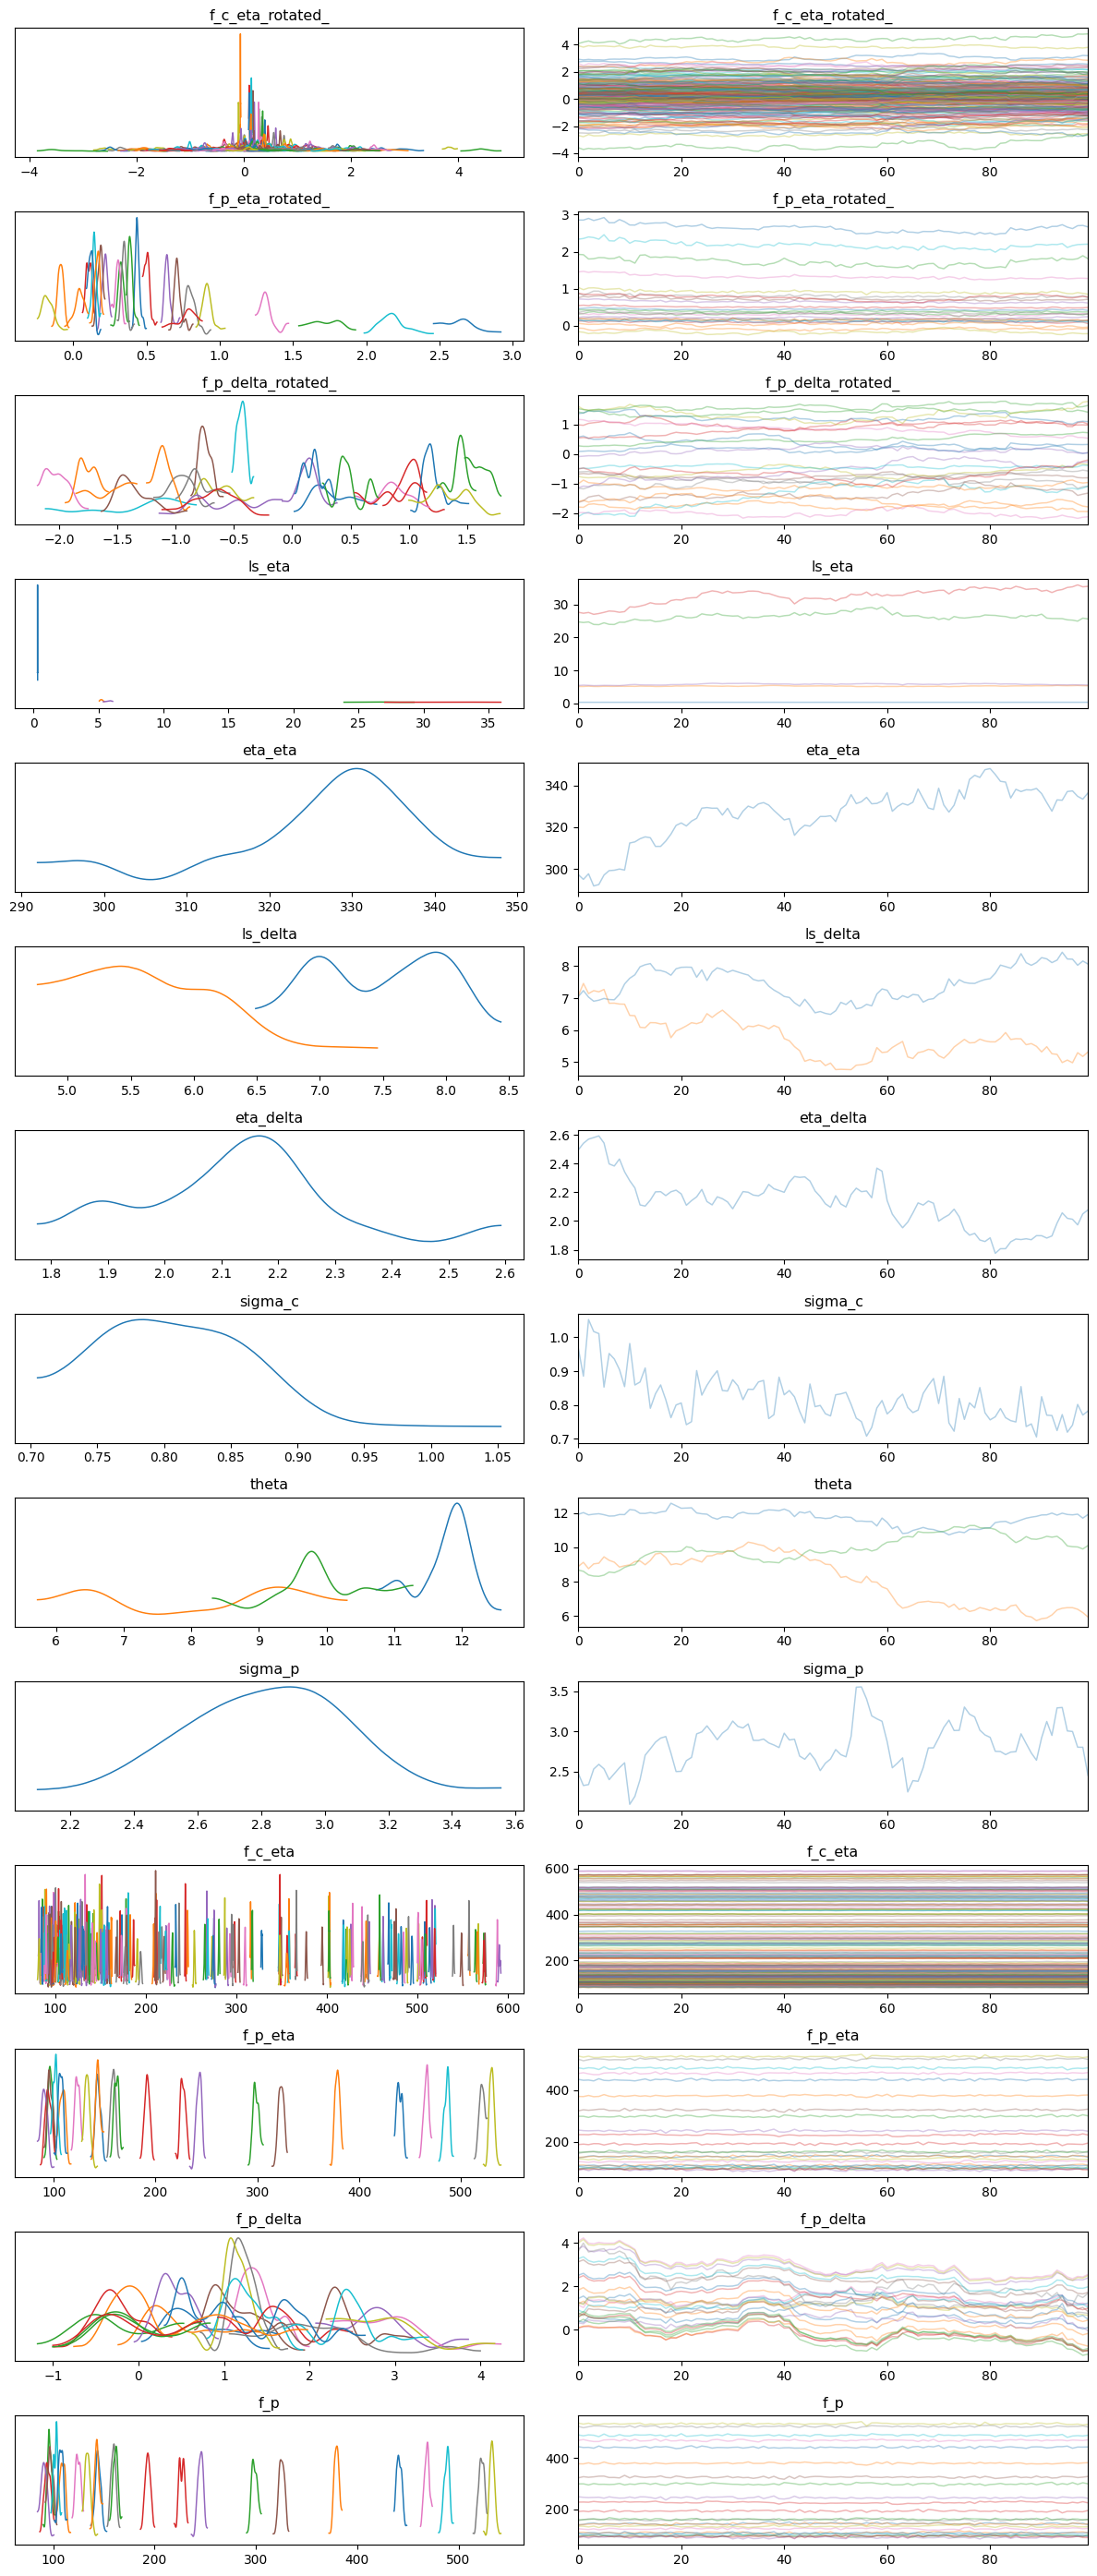

In [9]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [10]:
with koh_model:
    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_p_obs"],
    )

Sampling: [y_p_obs]


Output()

In [11]:
samples.posterior_predictive.y_p_obs.mean(axis=(0, 1))

<xarray.DataArray 'y_p_obs' (y_p_obs_dim_0: 24)> Size: 192B
array([144.49419931, 108.96471862,  96.35601353,  94.08992053,
        91.15680928,  97.67853292, 124.91704622, 159.22070255,
       133.93738637, 102.95783436, 107.22813807, 143.2711354 ,
       161.63889821, 193.16388722, 244.73881453, 325.67926577,
       468.34417391, 522.84644822, 533.35135661, 488.69188047,
       441.96132749, 379.30620539, 298.78412212, 226.81056084])
Coordinates:
  * y_p_obs_dim_0  (y_p_obs_dim_0) int64 192B 0 1 2 3 4 5 ... 18 19 20 21 22 23

In [12]:
y_p

array([143.62, 109.34,  95.08,  95.08,  90.93,  97.5 , 123.77, 159.02,
       134.83, 103.03, 107.19, 143.47, 161.26, 193.31, 245.43, 325.55,
       468.93, 522.19, 533.4 , 488.99, 442.05, 379.99, 299.  , 226.94])

## 부록: Marginal likelihood 이용한 버전 - 검증필요

In [11]:
# --- Marginal GP 모델 ---
with pm.Model() as koh_model_marginal:
    # 1. GP 하이퍼파라미터 및 세타(theta)에 대한 사전 분포 (기존과 동일)
    # 컴퓨터 모델 에뮬레이터 GP (eta)
    ls_eta = pm.Gamma("ls_eta", alpha=2, beta=0.5, shape=5)
    eta_eta = pm.HalfCauchy("eta_eta", beta=2)
    cov_eta = eta_eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls_eta)

    # 모델 불일치 함수 GP (delta)
    ls_delta = pm.Gamma("ls_delta", alpha=2, beta=0.5, shape=2)
    eta_delta = pm.HalfCauchy("eta_delta", beta=2)
    cov_delta = eta_delta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls_delta)

    # 관측 노이즈
    sigma_c = pm.HalfNormal("sigma_c", sigma=1)
    sigma_p = pm.HalfNormal("sigma_p", sigma=1)

    # 보정 파라미터 theta
    theta = pm.Uniform("theta", lower=0, upper=20, shape=3)

    # 2. 전체 공분산 행렬(Block Covariance Matrix) 구축
    # 컴퓨터 모델 입력값 (상수)
    X_c = np.hstack([x_c, t_c])
    # 물리 모델 입력값 (theta에 따라 변하는 심볼)
    X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)

    # Cov(y_c, y_c)
    K_cc = cov_eta(X_c)
    # Cov(y_c, y_p)
    K_cp = cov_eta(X_c, X_p)
    # Cov(y_p, y_p) = Cov(eta(X_p)) + Cov(delta(x_p))
    K_pp = cov_eta(X_p) + cov_delta(x_p)

    # 4개의 블록을 합쳐 전체 공분산 행렬 생성
    K_top = pt.concatenate([K_cc, K_cp], axis=1)
    K_bottom = pt.concatenate([K_cp.T, K_pp], axis=1)
    K_full = pt.concatenate([K_top, K_bottom], axis=0)

    # 3. 관측 노이즈 추가
    # 컴퓨터, 물리 모델 각각의 노이즈 분산을 대각 성분으로 갖는 벡터 생성
    diag_c = pt.full((X_c.shape[0],), sigma_c**2)
    diag_p = pt.full((X_p.shape[0],), sigma_p**2)
    noise_diag_vec = pt.concatenate([diag_c, diag_p])

    # 전체 공분산 행렬의 대각선에 노이즈와 수치 안정성을 위한 jitter 추가
    K_final = K_full + pt.diag(noise_diag_vec) + pt.eye(X_c.shape[0] + X_p.shape[0]) * 1e-6

    # 4. Marginal Likelihood 정의
    # 관측 데이터를 하나의 벡터로 결합
    y_combined = np.concatenate([y_c, y_p])

    # 결합된 데이터에 대한 다변수 정규분포로 가능도 정의
    y_obs = pm.MvNormal(
        "y_obs",
        mu=pt.zeros_like(y_combined),
        cov=K_final,
        observed=y_combined
    )

In [12]:
with koh_model_marginal:
    trace_marginal = pm.sample(
        draws=100, tune=100, chains=1, cores=1, nuts_sampler="numpyro",
        # rogressbar=False,                     # 여기
        # nuts_sampler_kwargs={"progress_bar": False}, 
    )

sample: 100%|██████████| 200/200 [07:55<00:00,  2.38s/it, 1023 steps of size 1.79e-03. acc. prob=0.97]
Only one chain was sampled, this makes it impossible to run some convergence checks


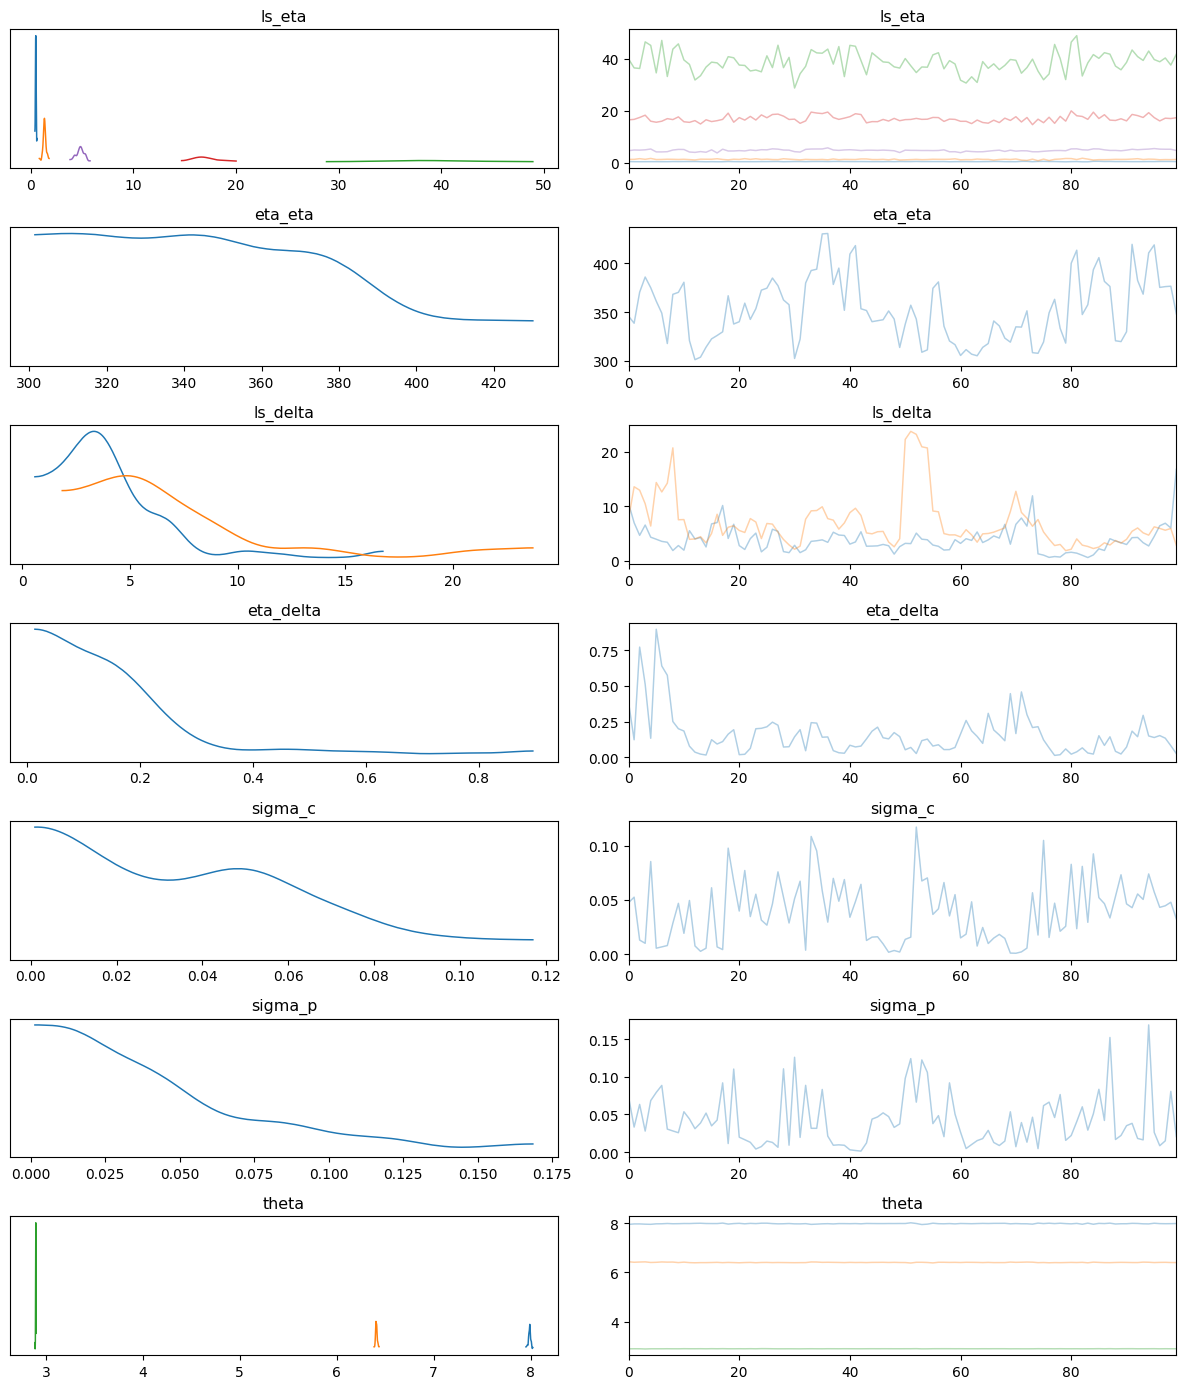

In [14]:
az.plot_trace(trace_marginal)
plt.tight_layout()
plt.show()

In [18]:
trace_marginal.posterior.theta.mean(axis=(0, 1))

<xarray.DataArray 'theta' (theta_dim_0: 3)> Size: 24B
array([7.98810987, 6.40889937, 2.89530279])
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2

In [20]:
with koh_model_marginal:
    samples = pm.sample_posterior_predictive(
        trace_marginal,
        var_names=["y_obs"],
    )

Sampling: [y_obs]


Output()

In [24]:
samples.posterior_predictive.y_obs.mean(axis=(0, 1))

<xarray.DataArray 'y_obs' (y_obs_dim_0: 264)> Size: 2kB
array([ 19.51349481,  30.74066902,  -4.86321602,  26.52251546,
         3.206962  ,  15.26746883,  23.13575537, -37.2898581 ,
       -20.56318221, -10.45200439,  18.2996809 ,  21.77539547,
        41.72423024,  26.19623426, -17.88986227,   9.01576913,
        27.49593687,  25.32383211,  33.43085613,  11.53724047,
        13.75993333,  -4.37623493,  53.60698031,  47.32005391,
        18.7809451 ,  28.56314953,  -4.80549769,  21.5426924 ,
         1.83604795,  15.06760034,  23.255216  , -40.0248159 ,
       -21.90720804,  -9.07188579,  15.5039433 ,  18.63729123,
        39.82673109,  25.6982029 , -21.25645452,   3.80613056,
        21.28959801,  29.48813053,  26.94375225,   8.62547557,
        16.73843266,  -5.01323921,  56.840037  ,  50.39245415,
        17.6902188 ,  26.70194953,  -4.05082036,  22.04759287,
         5.35511448,  22.42012318,  22.42999377, -37.96887031,
       -20.91328708,  -9.84122424,  23.25118852,  25.11438952,
        39.34521745,  25.54391322, -17.82750891,  12.19103195,
        27.6190706 ,  31.74901411,  33.90829776,  12.43177796,
        15.15669205,  -1.5386375 ,  47.67288721,  41.00718026,
        20.04838894,  30.32451686,  -5.19446651,  26.33418741,
         5.36613091,  19.21579768,  22.90587238, -35.40505459,
...
        24.01361797,  30.44126234,  29.92093426,   6.27156544,
        16.12653385,  -3.00602682,  54.58328861,  48.33958104,
        18.28630879,  27.88846732,  -4.21151805,  23.48891091,
         5.211377  ,  21.41729812,  22.7627128 , -37.1549777 ,
       -20.45103296, -10.10126373,  22.92395563,  25.34473459,
        40.07614665,  25.73138722, -17.27922329,  12.49092092,
        28.36163712,  29.80827098,  34.60165329,  12.95462833,
        14.5253058 ,  -1.90043795,  48.31211886,  41.73605183,
        19.75564943,  25.49140801,  -6.56922532,  18.90929798,
         8.7113111 ,  24.52000873,  20.23761893, -39.93120428,
       -23.25680319,  -7.45755488,  24.20990314,  27.27285248,
        38.10043606,  25.28270781, -20.87638431,   9.37760679,
        26.80345216,  35.17762169,  33.26681809,   5.08477584,
        16.73747741,   0.72363316,  48.3442693 ,  41.77954492,
        18.89394663,  28.10628552,  -4.0143004 ,  21.87411779,
         4.84652325,  19.7596249 ,  22.0959014 , -38.21587729,
       -21.81415001,  -9.02032368,  20.5983909 ,  22.88377   ,
        39.66033662,  25.73725281, -19.77212231,   8.56609095,
        25.77767191,  31.27534671,  32.15093025,   9.00032664,
        16.05943614,  -1.89846263,  51.71912288,  45.18832076])
Coordinates:
  * y_obs_dim_0  (y_obs_dim_0) int64 2kB 0 1 2 3 4 5 ... 258 259 260 261 262 263

In [25]:
y_combined

array([128.62,  96.13,  85.19,  85.19,  81.71,  86.83, 112.06, 148.82,
       126.12,  94.66,  93.28, 121.9 , 142.  , 172.74, 222.57, 302.81,
       438.93, 490.33, 501.68, 460.74, 417.17, 357.69, 280.19, 210.02,
       131.7 ,  96.25,  85.56,  85.56,  81.97,  87.45, 111.79, 145.9 ,
       123.76,  93.84,  92.84, 128.27, 154.93, 192.91, 252.74, 347.85,
       507.27, 557.17, 563.35, 506.67, 447.29, 377.2 , 292.39, 217.93,
       138.3 , 108.43,  95.8 ,  95.8 ,  91.44,  98.73, 123.27, 153.41,
       130.28, 101.47, 105.09, 137.31, 153.02, 182.04, 229.59, 298.23,
       426.79, 474.25, 484.26, 444.14, 401.87, 346.9 , 274.56, 211.2 ,
       138.89, 106.4 ,  93.03,  93.03,  89.09,  95.1 , 121.9 , 159.55,
       135.18, 102.2 , 104.17, 134.57, 149.63, 177.4 , 223.54, 295.81,
       424.92, 479.13, 493.56, 458.96, 421.79, 366.04, 289.48, 219.71,
       133.19,  99.32,  88.16,  88.16,  84.46,  90.1 , 115.36, 150.87,
       127.91,  96.83,  96.24, 129.58, 149.46, 181.7 , 233.63, 315.7 ,
      